In [55]:
import torch
import os
import random

from torch_geometric.loader import DataLoader
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

import matplotlib.pyplot as plt

In [56]:
train_dir = "D:\\Baburam\\Graph Project\\landmarks_to_graphs\\train"
validation_dir = "D:\\Baburam\\Graph Project\\landmarks_to_graphs\\validation"

In [57]:
train_set = list()
validation_set = list()

for file in os.listdir(train_dir):
    train_set.append(os.path.join(train_dir, file))

for file in os.listdir(validation_dir):
    validation_set.append(os.path.join(validation_dir, file))

In [58]:
print(f"Number of graphs in train set: {len(train_set)}")
print(f"Number of graphs in validation set: {len(validation_set)}")

Number of graphs in train set: 26613
Number of graphs in validation set: 6549


In [59]:
train_dataset = list()
for data in train_set:
    train_dataset.append(torch.load(data))

validation_dataset = list()
for data in validation_set:
    validation_dataset.append(torch.load(data))

In [60]:
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True)
validation_loader = DataLoader(validation_dataset, batch_size = 128, shuffle = True)

## GCNConv

In [61]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(3, 32)
        self.conv2 = GCNConv(32, 16)
        self.lin = Linear(16, 7)
      
    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        
        # 2. Readout layer
        x = global_mean_pool(x, batch) # [batch_size, hidden_channels]
        
        # 3. Apply a final classifier
        x = F.dropout(x, p=0.2, training=self.training)
        
        return x

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
print(model)

GCN(
  (conv1): GCNConv(3, 32)
  (conv2): GCNConv(32, 16)
  (lin): Linear(in_features=16, out_features=7, bias=True)
)


In [47]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

In [48]:
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.


In [49]:
train_accuracy = list()
val_accuracy = list()
for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    val_acc = test(validation_loader)
    train_accuracy.append(train_acc)
    val_accuracy.append(val_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Validation Acc: {val_acc:.4f}')

Epoch: 001, Train Acc: 0.2584, Validation Acc: 0.2677
Epoch: 002, Train Acc: 0.2584, Validation Acc: 0.2677
Epoch: 003, Train Acc: 0.2634, Validation Acc: 0.2730
Epoch: 004, Train Acc: 0.2584, Validation Acc: 0.2677
Epoch: 005, Train Acc: 0.2584, Validation Acc: 0.2677
Epoch: 006, Train Acc: 0.2587, Validation Acc: 0.2681
Epoch: 007, Train Acc: 0.2587, Validation Acc: 0.2678
Epoch: 008, Train Acc: 0.2584, Validation Acc: 0.2677
Epoch: 009, Train Acc: 0.2585, Validation Acc: 0.2677
Epoch: 010, Train Acc: 0.2586, Validation Acc: 0.2680
Epoch: 011, Train Acc: 0.2591, Validation Acc: 0.2689
Epoch: 012, Train Acc: 0.2587, Validation Acc: 0.2678
Epoch: 013, Train Acc: 0.2791, Validation Acc: 0.2857
Epoch: 014, Train Acc: 0.2609, Validation Acc: 0.2698
Epoch: 015, Train Acc: 0.2670, Validation Acc: 0.2761
Epoch: 016, Train Acc: 0.2752, Validation Acc: 0.2828
Epoch: 017, Train Acc: 0.2773, Validation Acc: 0.2868
Epoch: 018, Train Acc: 0.2637, Validation Acc: 0.2721
Epoch: 019, Train Acc: 0.259

[]

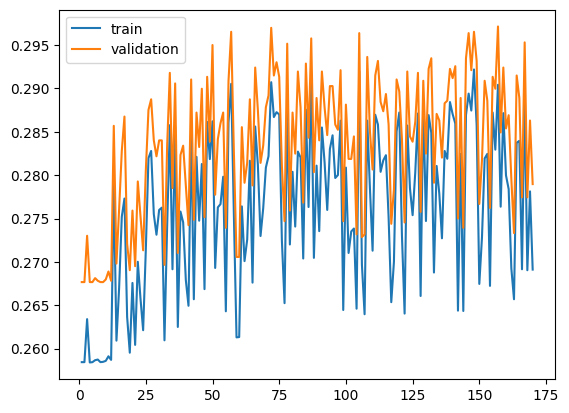

In [51]:
# Plotting
epochs = [i for i in range(1, 171)]
plt.plot(epochs, train_accuracy, label='train')
plt.plot(epochs, val_accuracy, label='validation')
plt.legend()
plt.plot()

## GraphConv

In [74]:
from torch_geometric.nn import GraphConv

class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(3, 64)
        self.conv2 = GraphConv(64, 32)
        # self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(32, 7)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        # x = x.relu()
        # x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)

        # x = F.dropout(x,, training=self.training)
        x = self.lin(x)
        
        return x

In [75]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GNN().to(device)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.015, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

GNN(
  (conv1): GraphConv(3, 64)
  (conv2): GraphConv(64, 32)
  (lin): Linear(in_features=32, out_features=7, bias=True)
)


In [76]:
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()
    correct = 0
    for data in loader:  # Iterate in batches over the training/test/validation dataset.
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

In [77]:
train_accuracy = list()
val_accuracy = list()
epochs = 200
for epoch in range(1, epochs+1):
    train()
    train_acc = test(train_loader)
    val_acc = test(validation_loader)
    train_accuracy.append(train_acc)
    val_accuracy.append(val_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Validation Acc: {val_acc:.4f}')

Epoch: 001, Train Acc: 0.2598, Validation Acc: 0.2695
Epoch: 002, Train Acc: 0.2769, Validation Acc: 0.2819
Epoch: 003, Train Acc: 0.3166, Validation Acc: 0.3165
Epoch: 004, Train Acc: 0.3044, Validation Acc: 0.3101
Epoch: 005, Train Acc: 0.2924, Validation Acc: 0.2952
Epoch: 006, Train Acc: 0.3137, Validation Acc: 0.3089
Epoch: 007, Train Acc: 0.3440, Validation Acc: 0.3486
Epoch: 008, Train Acc: 0.3215, Validation Acc: 0.3262
Epoch: 009, Train Acc: 0.3346, Validation Acc: 0.3372
Epoch: 010, Train Acc: 0.3478, Validation Acc: 0.3517
Epoch: 011, Train Acc: 0.3413, Validation Acc: 0.3397
Epoch: 012, Train Acc: 0.3348, Validation Acc: 0.3381
Epoch: 013, Train Acc: 0.3369, Validation Acc: 0.3358
Epoch: 014, Train Acc: 0.3454, Validation Acc: 0.3521
Epoch: 015, Train Acc: 0.3371, Validation Acc: 0.3381
Epoch: 016, Train Acc: 0.3499, Validation Acc: 0.3452
Epoch: 017, Train Acc: 0.3052, Validation Acc: 0.3065
Epoch: 018, Train Acc: 0.3442, Validation Acc: 0.3430
Epoch: 019, Train Acc: 0.352

[]

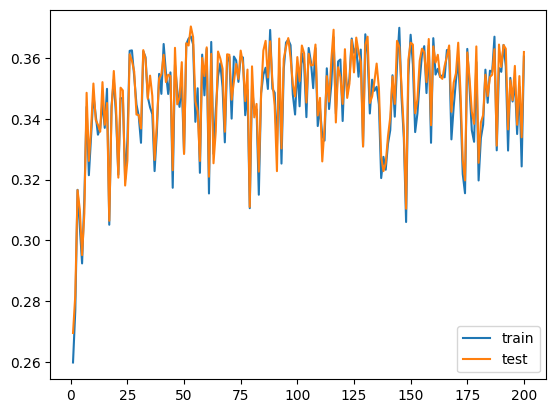

In [78]:
# Plotting
epochs = epochs + 1
epochs = [i for i in range(1, epochs)]
plt.plot(epochs, train_accuracy, label='train')
plt.plot(epochs, val_accuracy, label='test')
plt.legend()
plt.plot()